# **Distributed graph embedding from cosmological simulations**

**Group 13**:

|student|email|ID|
|---|---|---|
|Lorenzo Cavezza|lorenzo.cavezza@studenti.unipd.it|2130648|
|Giulia Doda|giulia.doda@studenti.unipd.it|2104267|
|Giacomo Longaroni|giacomo.longaroni@studenti.unipd.it|2126898|
|Laura Ravagnani|laura.ravagnani@studenti.unipd.it|2104271|

### Introduction

Estimating cosmological parameters from the analysis of cosmic web structures is a key goal in cosmology since it helps us to uncover fundamental properties of the universe. The cosmic web is the large-scale structure of the universe, composed by galaxy clusters and filaments, and some important cosmological parameters from the $\Lambda \text{CDM}$ model (the most trusted model nowadays) are for example $\Omega_{m}$, which is the total matter density, and $\sigma_{8}$, which measures matter density fluctuations on a scale of $8\, \text{Mpc}$ (recalling that $1 \,\text{pc} \sim 3.26 \,\text{light years} \sim 31 \,\text{x}\, 10^{16} \,\text{m}$). 
<div class="container" style="display: inline-block;">
  <figure>
    <div style="padding: 10px; text-align: center;">
      <img src='cosmicweb.png' style="width: 450px; height: 250px;" />
      <figcaption><br>Fig. 1: the cosmic web.</b></figcaption>
    </div>
  </figure>
</div>

These parameters are traditionally estimated using summary statistics, such as the power spectrum. However, recent advances in machine learning have opened up a promising new approach. For example, **graph neural networks** (GNN) offers many advantages specifically for this task with respect to other types of neural networks (NN). Let’s first recall that a graph consists of a set of nodes connected by edges, that here we consider as symmetrical links between nodes (without a preferred direction). Both nodes and edges can be associated with data. Moreover, we can associate global features with the graph that are related to the entire graph rather than to nodes or edges. A GNN is then a NN that takes graphs as input and can make predictions about node or edge properties, or properties of the graph as a whole. This type of network offers many advantages for the cosmology task.  First of all, it is inherently permutation invariant, and we can design it to respect physical symmetries relevant to our task, such as rotation and translation invariance, so that the network can focus on learning relevant correlations. Another advantage is that, unlike some other network models like convolutional NN (CNN), GNN do not impose any cut in scale.  In CNN, the grid size determines the minimum scale, requiring a cutoff because CNN cannot handle arbitrarily fine grids due to memory limitations. In particular, when dealing with nonlinear scales, CNN need very fine grids, which are not feasible with current computational architectures. Finally the cosmic web can be easily represented as a graph and processing it with a GNN is more appropriate since a graph neural network handle sparse and irregular data, such as the cosmic web, more effectively.

Our goal is then to embed the cosmic web from simulated data into a graph so that it can be further processed by a GNN.
<div class="container" style="display: inline-block;"> 
    <figure>
      <div style="padding: 10px; text-align: center;">
        <img src='graph_8_997.jpeg' style="width: 450px; height: 450px;">
        <figcaption><br>Fig. 2: example of a cosmic graph from a simulation represented in 3D space.</b></figcaption>
      </div>
    </figure>
</div>

#### The data
Quijote is a suite of N-body simulation containing many different catalogues. We focus specifically on the halo catalogue at redshift $z=1$. This provides us with $2000$ dark matter halo simulations, where the halos are already identified by the friends of friends (FoF) algorithm. Each simulations contains $512^3$ particles in a comoving volume of $1\,\text{Gpc}$. The simulations are generated through latin hypercube and each of them is associated with different values for the cosmological parameters. 

#### The method
We need to embed each simulation into a graph. First, we find all halo pairs within a distance equal to or less than the linking radius, which we set at $0.2\,\text{Gpc} $, following previous studies. Next, we extract the translation and rotation invariant features: the distance between connected halos and two angles that specify the position of each linked halo pair relative to the halos' centroid. It's important to note that all distance calculations apply periodic boundary conditions, to account for the limitations of the simulation box.
<div class=\"container\" style=\"display: inline-block;\"> 
    <figure>
      <div style="padding: 10px; text-align: center;">
        <img src='graph_embedding_space.png' style="width: 350px; height: 250px;">
        <figcaption><br>Fig. 3: graph embedding space.</b></figcaption>
      </div>
    </figure>
</div>

Here we can easily visualize the graph embedding. Each node represents a halo, with its corresponding feature being the halo mass. The graph edges must account for gravitational interactions between halos and respect the required symmetries. Graph edges are defined by: 
- the linking distance $d$ between linked halos normalized by the linking radius, 
- the cosines of the two angles describing the position of the linked halo pair relative to the centroid of the halos. 

Finally, we also assign a global feature to each graph $u = log_{10}N$ where $N$ is the total number of halos in the simulation to summarize the cardinality of the graph.

#### Resources and cluster (TO DO BETTER)
- 4 virtual machines on CloudVeneto (4 VCPUs, 8GB RAM, 25GB storage)
  - VM1: 
    - hosting the Spark Master and a Spark worker
    - with a 250 GB volume mounted on
    - network file system (NFS) server 
  - VM2 $\rightarrow$ VM4: 
    - Spark workers
    - NFS clients

In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .config("spark.executor.memory", "6g")\
        .config("spark.executor.cores", 4)\
        .getOrCreate()

sc = spark.sparkContext

numPartitions = 32

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/16 13:42:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Functions

In [22]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF



# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix



# To assign simulation keys to each point in each simulation
def assign_key_to_rows(key_value_pair):

    key, array = key_value_pair

    return [(key, row) for row in array]



# To assign each value of the rdd to each bin
def bin_placer(value, edges):

    for i in range(1, len(edges)):
        if value < edges[i]:
            return edges[i - 1]
        
    return edges[-1]



# mass cuts distribution histogram
def create_mass_hist(mass_rdd):

    # bin edges 
    min_mass_cuts = mass_rdd.map(lambda x: x[1]).reduce(min)
    max_mass_cuts = mass_rdd.map(lambda x: x[1]).reduce(max)

    # number of bins
    num_bins = 70      

    # bin width
    bin_width = 1e13
    bins = np.arange(0, max_mass_cuts + bin_width, bin_width)

    # edges
    edges = [min_mass_cuts + i * bin_width for i in range(int(num_bins) + 1)]

    # histogram with map - reduce
    mapred_mass_cuts = mass_rdd.map(lambda x: (bin_placer(x[1], edges), 1))\
                                .reduceByKey(lambda x, y: x + y)
    mass_cuts_distr = np.array(mapred_mass_cuts.collect())

    # create figure
    fig, ax = plt.subplots(figsize=(10,6))

    ax.hist(mass_cuts_distr[:, 0], bins=bins, weights=mass_cuts_distr[:, 1], color='#0f5e6f', alpha=0.4, label='Mass distribution')
    ax.set_xlabel('Halo mass ($M_{\\odot}$)', fontsize=14)
    modot = '$M_{\\odot}$'
    b_width = "{:.2e}".format(bin_width)
    ax.set_ylabel('Counts  / $1\\times 10^{13}$' + modot, fontsize=14)
    ax.grid(alpha=0.4, linestyle='--')

    


# number of halos distribution histogram
def create_halos_hist(halos_rdd, n_sims):
    
    # bin edges 
    min_n_halos = halos_rdd.map(lambda x: x).reduce(min)
    max_n_halos = halos_rdd.map(lambda x: x).reduce(max)

    # number of bins
    num_bins_halos = 20

    # bin width
    bin_width_halos = (max_n_halos - min_n_halos) / num_bins_halos

    # edges
    edges_halos = [min_n_halos + i * bin_width_halos for i in range(num_bins_halos + 1)]

    # histogram with map - reduce
    mapped_n_halos = halos_rdd.map(lambda x: (bin_placer(x, edges_halos), 1))
    reduced_n_halos = mapped_n_halos.reduceByKey(lambda x, y: x + y)
    n_halos_distr = np.array(reduced_n_halos.collect())

    # create histogram
    fig1, ax1 = plt.subplots(figsize=(10,6))

    ax1.hist(n_halos_distr[:, 0], bins=num_bins_halos, weights=n_halos_distr[:, 1], color='#f28a44', alpha=0.6, label='Mass distribution')
    ax1.set_xlabel('# of halos', fontsize=14)
    ax1.set_ylabel(f'Counts  /  {bin_width_halos} # halos', fontsize=14)
    ax1.grid(alpha=0.4, linestyle='--')



# create all the possible halo pairs inside each box
def create_pairs(idx_pos_box_rdd):

    # obtain all the possible point pairs for each simulation clustered by boxes
    # --> ( (simkey_boxkey, (idx, array)), (simkey_boxkey, (idx, array)) )
    cartesian_rdd = idx_pos_box_rdd.groupByKey()\
                            .flatMapValues(lambda points: [(p1,p2) for p1 in points for p2 in points])\
                            .map(lambda x: ((x[0], x[1][0]),(x[0], x[1][1])))
    
    # compute differences between every pair 
    # --> (simkey_boxkey, (idx1, idx2, coord1, coord2, diff_coord))
    diff_rdd = cartesian_rdd.map(lambda x:(x[0][0],(x[0][1][0], x[1][1][0], x[0][1][1],  x[1][1][1] , x[0][1][1] - x[1][1][1])))
    
    # --> (simkey_boxkey, (idx1, idx2, coord1, coord2, diff_coord, norm))
    pairs_dist_rdd_with_box = diff_rdd.mapValues(lambda x: (x[0], x[1], x[2], x[3], x[4], np.linalg.norm(x[4])))
    pairs_dist_rdd = pairs_dist_rdd_with_box.map(lambda x: (int(x[0].split('_')[0]), (x[1])))\
                                                   .map(convert_to_tuple)\
                                                   .distinct()\
                                                   .map(convert_to_array)
    
    return pairs_dist_rdd



# Plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx:

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color='mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()



def get_edge_attributes(pos_rdd, linked_pairs_dist_rdd):
    # centroids positions
    halo_centroids = pos_rdd.reduceByKey(lambda x, y: (x + y) / 2)

    # joined rdd with halo centroids positions
    joined_rdd = linked_pairs_dist_rdd.join(halo_centroids)

    # distance between each point from each pair and halo centroid
    row_col_diff_rdd = joined_rdd.mapValues(
        lambda x: (
            x[0][0],        # idx_i
            x[0][1],        # idx_j
            x[0][2] - x[1], # row
            x[0][3] - x[1], # col
            x[0][4],        # diff
            x[0][5]         # dist
            ))

    # normalizing 
    normalized_rdd = row_col_diff_rdd.mapValues(
        lambda x: (
            x[0],                      # idx_i
            x[1],                      # idx_j
            x[2]/np.linalg.norm(x[2]), # row_normalized
            x[3]/np.linalg.norm(x[3]), # col_normalized
            x[4]/np.linalg.norm(x[4]), # s_ij
            x[5]/0.2                   # |d_ij|/r 
        )
    )

    # edge attributes
    edge_attr_rdd = normalized_rdd.mapValues(
        lambda x: (
            x[0],
            x[1],
            np.dot( x[2].T, x[3] ), # cos(alpha)
            np.dot( x[2].T, x[4] ), # cos(beta)
            x[5]                    # |d_ij|/r 
        )
    )

    return edge_attr_rdd



# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f



# Create graph object
def create_graph(element):

    sim_graph = graph(
        np.array(element[0])[:,3],   # node_f = masses
        np.array(element[0])[:,0:3], # pos
        np.array(element[3]),        # sim_pars
        np.array(element[2]),        # glob_f
        np.array(element[1])[:,0:2], # edge_idx
        np.array(element[1])[:,2:5], # edge_f
    )

    return(sim_graph)



# Function that returns the partitions bounds as a dictionary of lists of tuples, 
# each tuple being the min and max of a dimension
def sub_box_bounds(box_number, r_link):

    sub_length = 1.0 / box_number # partition length
    bounds = {}
    base = 'box'
    sub_box_counter = 1

    for x in range(0, box_number):
        for y in range(0, box_number):
            for z in range(0, box_number):
                key = base + str(sub_box_counter)
                single_bounds = []
                centre = [x, y, z] # vertex of a sub_box corresponding to min x,y,z
                for i in range(3):
                    min_bound = round(max(0, centre[i] * sub_length - 0.5 * r_link), 2)
                    max_bound = round(min(1, centre[i] * sub_length + sub_length + 0.5 * r_link), 2)
                    single_bounds.append((min_bound, max_bound))
                bounds[key] = single_bounds
                sub_box_counter += 1

    return bounds



# Assign each point to a box
def assign_box(point, boxes):

    position = point[1]
    x, y, z = position
    box_assign = []
    
    for box_name, ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in boxes.items():
     if (x_min <= x <= x_max) and (y_min <= y <= y_max) and (z_min <= z <= z_max):
           box_assign.append((box_name, point))
    
    return box_assign



# Convert all element of an rdd into a tuple
def convert_to_tuple(data):

    return (
        data[0],
        data[1][0],
        data[1][1],
        (float(data[1][2][0]), float(data[1][2][1]), float(data[1][2][2])),  # from array to tuple
        (float(data[1][3][0]), float(data[1][3][1]), float(data[1][3][2])),  # from array to tuple
        (float(data[1][4][0]), float(data[1][4][1]), float(data[1][4][2])),  # from array to tuple
        float(data[1][5])             
    )



# Convert vectors of an rdd into a np.array (key, ( ...)) 
def convert_to_array(data):
    
    return (
        data[0],
        (
            data[1],
            data[2],
            np.array([float(data[3][0]), float(data[3][1]), float(data[3][2])]),  # from tuple to array
            np.array([float(data[4][0]), float(data[4][1]), float(data[4][2])]),  # from tuple to array
            np.array([float(data[5][0]), float(data[5][1]), float(data[5][2])]),  # from tuple to array
            float(data[6]) # to standard float
        )
    )

## 1. Reading the files

The different parameters of the simulations are stored in a text file called ```latin_hypercube_params.txt```. It is structured with columns that contain the following parameters for each simulation:

|Parameter|range|
|---|---|
|$\Omega_m$|[0.1; 0.5]|
|$\Omega_b$ (baryonic matter density)|[0.03; 0.07]|
|$h$ (reduced Hubble constant)|[0.5; 0.9]|
|$n_s$ (scalar spectral index)|[0.8; 1.2]|
|$\sigma_8$|[0.6; 1.0]|

The simulation files instead contain information about every single DM halo in that space. In order to distribute the files across the nodes we first parallelize the path list, built with a (key, value) structure where the key is the number of the simulation.
The files are then read with the function ```read_cosmo_data``` that uses [Pylians3 readfof](https://github.com/franciscovillaescusa/Pylians3/blob/master/library/readfof.py) library to get the halos attributes and put them into an RDD. From the RDD just created we retrieve only the halo positions (in Gpc/h) and mass (in $M_\odot$ /h) using the function ```get_pos_mass``` and build the corresponding RDD. In order to distribute the simulation key to each point we apply the ```assign_key_to_rows``` function using a ```flatMap()``` transformation.\
Due to computing memory capabilities it is necessary to apply a filter to keep only the most massive halos, in particular for each graph we discard the 99.7% of the total mass, meaning that for every simulation the value of mass cut is different from the others. These values are stored in ```mass_cut_rdd```. To perform a global mass cut is not possible for our resurces since a loose global mass cut is computationally unfeasible and a tight one would return some empty graphs.

In [4]:
# simulations parameter
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

# number of simulations to be processed
n_sims = 2000

# path list with simulation keys
path_list = [(i, "/mnt/cosmo_GNN/Data/" + str(i)) for i in range(n_sims)]

# parallelize path list and read files
fof_rdd = sc.parallelize(path_list, numSlices=numPartitions)\
            .mapValues(read_cosmo_data)

# get positions and masses for each point
pos_mass_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .flatMap(assign_key_to_rows)

# cut percentile
cut = 0.997

# get mass cuts 
mass_cut_rdd = fof_rdd.mapValues(get_pos_mass)\
                      .mapValues(lambda x: np.quantile(x[:, -1], cut))

#### Mass and halos Histograms

Since we do not apply any global mass cut to our dataset, we analyze the distribution of mass cuts across all simulations. Having a rough estimate of the mass cut values is important for future applications on different datasets.\
To do so we apply the *MapReduce* paradigma: we map each element of `mass_cut_rdd` into a key-value pair where the key identifies the bin and the value is 1. Then a simple `reduceByKey()` sums all the values in a given bin rendering the final histogram.\
We can observe that the mass cut distribution of the simulations is not uniform, translating in a non-uniform distribution of the simulation masses.

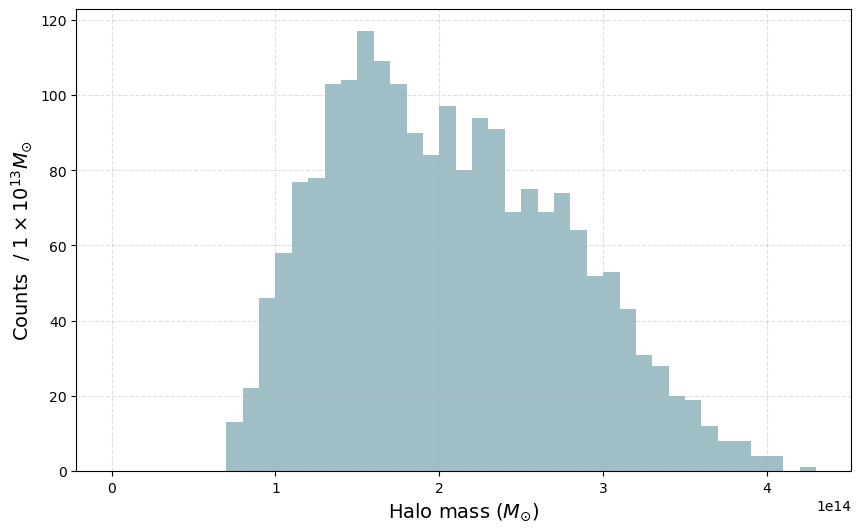

In [18]:
create_mass_hist(mass_cut_rdd)

We now perform the mass cut on the rdd using the `filter()` transformation and trigger it by applying `countByKey()` to count the number of halos that remain in each simulation. With the new RDD `n_halos_rdd` we again build an histogram to see the number of halos distribution in a similar way than before. We obtain a distribution of number of halos similar to the mass cut one.

In [6]:
# collect mass cuts into numpy array
mass_cuts = mass_cut_rdd.values().collect()
mass_cuts = np.array(mass_cuts)

# filter by mass
pos_mass_rdd_filtered = pos_mass_rdd.filter(lambda x: x[1][-1] >= mass_cuts[x[0]])

# number of halos in each simulation
n_halos = pos_mass_rdd_filtered.countByKey()

# number of halos rdd
n_halos_rdd = sc.parallelize(n_halos.values(), numSlices=numPartitions)

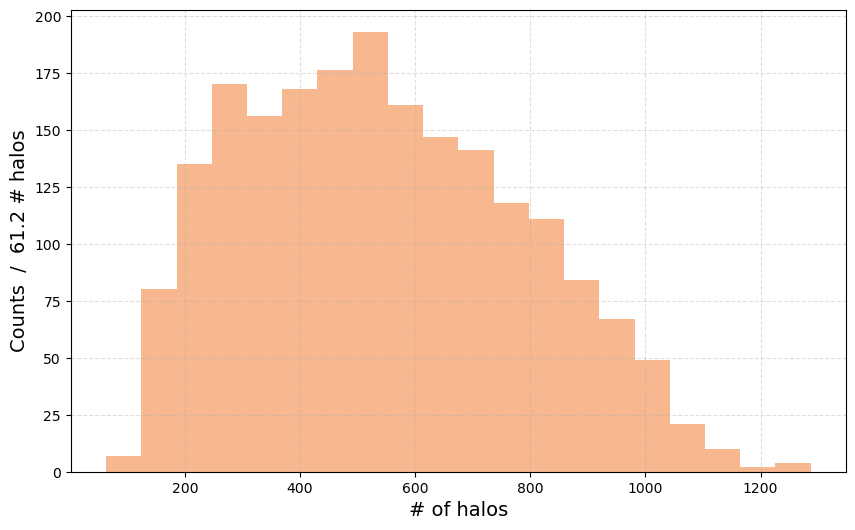

In [23]:
create_halos_hist(n_halos_rdd, n_sims=n_sims)

## 2. Clustering

### Algorithm

To build the graph we need to find the pairs of all the DM halos linked to each other. For this we must find all the points closer than the linking radius to every point in the simulation box. In the original project this was performed through the *KDTree* algorithm, which builds a tree over the box so that searching the closest points to a given one is very efficient. Making a search with this algortihm unfortunately implies having all the points at hand or at least having a copy of the tree in each partition, making it challenging to parallelize. For this reason we proceed with an "optimized brute force" approach.

Due to the computational cost of finding all the halo pairs with the brute force algorithm, which scales as $\mathcal{O}(n^2)$ over $n$ particles, we opted to parallelize the computation across sub-boxes to take advantage of the local nature of the interactions. The original simulation box is divided into $m^3$ sub-boxes (with $m$ divisions along each dimension). As shown in the following figures each sub-box has a length $l = \frac{1}{m} + r$, where the excess $r$ is necessary to create an overlap region that accounts for particle pairs near the borders of adjacent sub-boxes.

<div class="container" style="display: inline-block;">
  <figure>
    <div style="padding: 10px; text-align: center;">
      <img src='/benchmark/SubBoxes.png' style="width: 450px; height: 250px;" />
      <figcaption><br>Fig. 4: sub-boxes schema.</b></figcaption>
    </div>
  </figure>
</div>


### Implementation

We begin by defining the boundaries of the sub-boxes using the `sub_box_bound()` function. For each simulation, we then extract the positions of the nodes and assign an index to each node using the `groupByKey()` and `flatMapValues()` transformations. Next, we map the `assign_box()` function to modify the key by adding the assigned sub-box name for each point.

The `idx_pos_box_rdd` now contains the position of each point, its index, and a key that defines the corresponding simulation and sub-box to which the point belongs, from this we can follow the pipeline in the `create_pairs()` function to pair together the nodes.\
This function first performs a cartesian product within each sub-box for every simulation using `flatMapValues()`, generating node pairs along with their distances. Finally, it removes the sub-box keys and performs a `distinct()` transformation to eliminate any duplicates that may occur in the overlapping regions.

The new RDD, `linked_pairs_dist_rdd`, contains all the possible pairs within each sub-box for every simulation. We then filter these pairs by their distance, using the linking radius to obtain the final set of pairs.

In [8]:
# creation of the boxes
boxes = sub_box_bounds(box_number=4, r_link=0.2)

In [9]:
# positions rdd ---> (simkey, pos)
pos_rdd = pos_mass_rdd_filtered.mapValues(lambda x: x[:3])

idx_pos_rdd = pos_rdd.groupByKey()\
                      .flatMapValues(lambda vals: enumerate(vals))

idx_pos_box_rdd = idx_pos_rdd.flatMapValues(lambda p: assign_box(p, boxes))\
                              .map(lambda x: (str(x[0]) + '_' + x[1][0], x[1][1]))

pairs_dist_rdd = create_pairs(idx_pos_box_rdd)

# filter by linking radius
linked_pairs_dist_rdd = pairs_dist_rdd.filter(lambda x: x[1][-1] <= 0.2)

# pairs rdd --> (simkey, (idx1, idx2)) --> reverse pair already included
pairs_rdd = linked_pairs_dist_rdd.mapValues(lambda x: (x[0], x[1]))

It is now possible to visualize, for each simulation, the results with their graph in the 3D space, where a node is an halo and its mass defines the size. The connection between nodes correspond to the actual edges.

To build the plot from the RDD we set the simulation number and then `collect()` all the necessary information such as: position, mass and edge list.

In [10]:
# retrieve data for a simulation to show the plot
sim_num_plot = 8
pos_mass_rdd_filtered_plot = pos_mass_rdd_filtered.filter(lambda x: x[0] == sim_num_plot)\
                                                  .map(lambda x: x[1])
pos_mass_plot = np.array(pos_mass_rdd_filtered_plot.collect())
pos_plot = pos_mass_plot[:, :3]
mass_plot = pos_mass_plot[:, 3]
pairs_idx_plot = pairs_rdd.filter(lambda x: x[0] == sim_num_plot)\
                          .values()

pairs_idx_plot_array = np.array(pairs_idx_plot.collect())

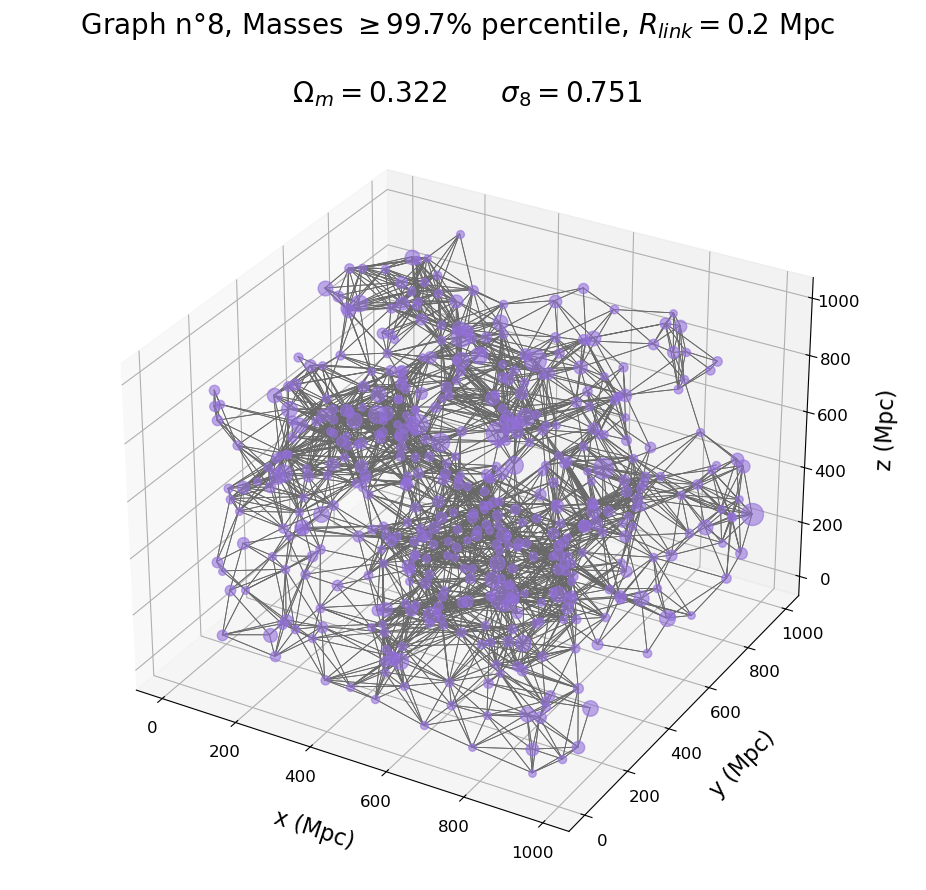

In [11]:
plot_graph_3D(sim_num_plot, sim_pars_file, pos_plot, mass_plot, pairs_idx_plot_array)

## 3. Graph creation

We define a dark matter halo graph as a tuple $\mathcal{G} = (u, V, E)$ where the elements are the following:
- *Global features* $u$: characterize the properties of the entire graph, in our case giving $N$ as the number of DM halos in the simulation
 $$ u = \log_{10} N $$

- *Node features* $V$: describe the features of each node of the graph, in our case the node masses
 $$V = M$$

- *Edge features* $E$: these features account for spatial information and define the edge attributes. Given the requirements of the physical problem, it is crucial that these features capture the spatial relationships between nodes while remaining invariant under both rotational and translational transformations. Translational symmetry can be ensured by expressing these features in terms of relative positions, while rotational symmetry can be introduced by using scalar products of the directional vectors relative to the graph's centroid. In this framework, for each edge between node *i* and node *j*, we assign a tuple of three features $$ E_{ij} = [|d_{ij}|/r, \alpha_{ij}, \beta_{ij}] $$ these three terms are defined as follows:

  -  $|d_{ij}|/r = \frac{|p_i - p_j|}{r}$ relative distance between nodes normalized by linking radius
  -  $\alpha_{ij} = n_i \cdot n_j$ is the scalar product between the direction vectors of nodes *i* and *j* with respect to the graph centroid, where $n_i = \frac{(p_i - \bar p)}{|p_i - \bar p|} $
  - $\beta_{ij} = n_i \cdot s_{ij}$ is the scalar product between the direction defined by node *i* ($n_i$) and the vector of direction between node *i* and node *j*: $s_{ij} = \frac{d_{ij}}{|d_{ij}|}$

The edge features are retrived by building sequentially different RDDs with `get_edge_attributes()` function, first we compute the halo centroids with `reduceByKey()`, then we `join()` these values to build an RDD that stores all the needings for computing the features. We then compute: direction vectors (`row` = $n_i$, `col` = $ n_j$), direction between nodes $s_{ij}$ and $|d_ij|/r$, at last we create the features RDD computing the scalar products and storing all the informations. 

In order to group the simulation points under a unique key we perform a `groupByKey()`. We do the same for the edge attributes RDD in order to help the following `join()`. The global features are simply retrieved from the `n_halos` dictionary computed before, then translated into an RDD with the corresponding simulation key.\
Following, the graph features RDDs, together with the simulation parameters RDD, are joined into a unique RDD in order to help the creation of the graphs.\
In the end the graphs are created with the function `create_graph`, that takes the newly joined RDD to assign its content to the graph class attributes.

In [12]:
# edge attributes
edge_attr_rdd = get_edge_attributes(pos_rdd, linked_pairs_dist_rdd)

# group by simulation
grouped_idx_pos_rdd = pos_mass_rdd_filtered.groupByKey()\
                                 .mapValues(list)

grouped_edge_rdd = edge_attr_rdd.groupByKey()\
                                .mapValues(list)

# parallelize simulation parameters file and global features
param_rdd = sc.parallelize([(i, el) for i, el in enumerate(sim_pars_file)], numSlices=numPartitions)
u = sc.parallelize([(i[0], math.log10(i[1])) for i in n_halos.items()], numSlices=numPartitions)

# graph rdd (a graph for each simulation)
# masses, positions, simulation parameters, global features, edge indexes, edge features
raw_graph_rdd = grouped_idx_pos_rdd.join(grouped_edge_rdd)\
                                   .join(u)\
                                   .join(param_rdd)\
                                   .mapValues(lambda x: (x[0][0][0], x[0][0][1], x[0][1], x[1]))

graph_rdd = raw_graph_rdd.mapValues(lambda x: create_graph(x))   

To trigger the previous transformations we perform a `count()` and then we call a graph attribute, `edge_idx`, to check the results. 

In [13]:
graph_rdd.count()

2000

In [14]:
graphs = graph_rdd.values().take(1)[0]

In [15]:
graphs.edge_idx

array([[ 96.,  54.],
       [ 22., 212.],
       [121., 125.],
       ...,
       [ 31.,  31.],
       [124.,   6.],
       [161., 161.]])

## 4. Benchmarks

In order to find the optimal cluster configuration and to analyze the permformance on different datasets we perform a gridsearch over some chosen parameters and estimate the time needed for the three different tasks: reading the data, clustering and creating the final graph.

The parameters are:
- Memory: 512 MB, 1 GB, 2 GB, 3 GB, 4 GB
- Mass Cut: 0.994 %, 0.995 %, 0.996 %, 0.997 %, 0.998 %
- \# of Partitions: 1, 4, 8, 16, 32
- \# of Cores: 1, 2, 3, 4 

We analyze the time needed to read the data and apply a mass cut over it varying all the parameters.
We then do the same for the clustering and graphing time varying all but the mass cut.

In [29]:
sc.stop()
spark.stop()